In [1]:
import numpy as np
import matplotlib.pyplot as plt
from src.c_country import C_Country
from utils.graph_generator import get_path

from utils.dotdict import dotdict
from utils.params import init_graph, get_centrum
from utils.params import GIRG_args1,GIRG_args2,GIRG_args3,GIRG_args4, get_moving


import seaborn as sn
import matplotlib.pyplot as plt
sn.set_theme(style="whitegrid")

import os
import pickle

In [2]:
args = {
    "--p_moving": 0.015, 
    "--p_worker": 1.0, 
    "--beta": 0.5,
    "--beta_super":0.0, 
    "--seed": 0,
    "--sigma": 1.0, 
    "--gamma": 0.2,
    "--max_sim": 500,
    "inf_agent_num":1000,
}

In [3]:
import pandas as pd
    
def save_to_file(betas, agg1, agg2, seed, filename):
    df = pd.DataFrame()
    for beta,sims in zip(betas,agg1):
        row = {"sim"+str(i):v for i,v in enumerate(sims)}
        row["beta"]=beta
        row["cen"]=True
        df = df.append(row, ignore_index=True)
    for beta,sims in zip(betas,agg2):
        row = {"sim"+str(i):v for i,v in enumerate(sims)}
        row["beta"]=beta
        row["cen"]=False
        df=df.append(row, ignore_index=True)
    df.to_csv(filename)

In [4]:
for seed in range(0,2):
    for config in [True, False]:
        print("Config" if config else "GIRG")
        for GIRG_args in [GIRG_args1 ,GIRG_args2, GIRG_args3, GIRG_args4]:
            GIRG_args["config_model"]=config
            GIRG_args["random_seed"]=seed
            graph = init_graph(GIRG_args)
            hun = C_Country(graph)

            pm = get_moving(graph, procent = 0.001)
            
            print(pm)

Config
0.07898134324549194
0.03853200225412213
0.02246266743039737
0.026650001092650047
GIRG
0.07898134324549194
0.03853200225412213
0.02246266743039737
0.026650001092650047
Config
0.12205335762195153
0.05755333845558045
0.03293333498000008
0.03936000242064016
GIRG
0.12205335762195153
0.05755333845558045
0.03293333498000008
0.03936000242064016


# GIRG

In [5]:
betas = np.concatenate(
    (np.linspace(args["--gamma"], 1.3*args["--gamma"], 12),
     np.linspace(1.3*args["--gamma"], 2.0*args["--gamma"], 15)[1:])
)

In [6]:
betas

array([0.2       , 0.20545455, 0.21090909, 0.21636364, 0.22181818,
       0.22727273, 0.23272727, 0.23818182, 0.24363636, 0.24909091,
       0.25454545, 0.26      , 0.27      , 0.28      , 0.29      ,
       0.3       , 0.31      , 0.32      , 0.33      , 0.34      ,
       0.35      , 0.36      , 0.37      , 0.38      , 0.39      ,
       0.4       ])

In [8]:
args["procnum"] = 30
args["simnum"] = 10
random_seed_num = 5

inf_city = 30

In [ ]:
%time

log_folder = "girgs_final"
if(not os.path.exists(log_folder)):
    os.makedirs(log_folder)

for seed in range(0, random_seed_num):
    print(f"\rRandom seed: {seed}/{random_seed_num}")
    for config in [True, False]:
        for GIRG_args in [GIRG_args1 ,GIRG_args2, GIRG_args3, GIRG_args4]:
            GIRG_args["config_model"]=config
            GIRG_args["random_seed"]=seed
            graph = init_graph(GIRG_args)
            hun = C_Country(graph)

            pm = get_moving(graph, procent = 0.001)
            args["--p_moving"]=pm

            centrum = get_centrum(graph, "k-core", inf_city)
            agg1 = hun.run_for_betas_simple_raw(args, centrum, betas, inf_city, "uniform_random")
            periphery = [n for n in graph.nodes() if n not in centrum] 
            agg2 = hun.run_for_betas_simple_raw(args, periphery, betas, inf_city, "uniform_random")

            graph_name = "Config" if config else "GIRG"
            tau = GIRG_args["tau"]
            alpha = GIRG_args["alpha"]
            filename = "{}/{}_tau:{}_alpha:{}_seed:{}.csv".format(
                log_folder, graph_name, tau, alpha,seed)
            
            save_to_file(betas, agg1, agg2, seed, filename)

In [15]:
def save_file(df, file):
    df_cen = df[df["cen"]==True].drop(['beta', 'cen'], axis=1).mean(1)
    df_per = df[df["cen"]==False].drop(['beta', 'cen'], axis=1).mean(1)
    betas = df[df["cen"]==True]["beta"]

    df_agg = pd.DataFrame()
    df_agg["betas"]=df[df["cen"]==True]["beta"]
    df_agg["mean1"]=df_cen
    df_agg["std1"]=df[df["cen"]==True].drop(['beta', 'cen'], axis=1).std(1)
    df_agg["mean2"]=np.array(df_per)
    df_agg["std2"]=np.array(df[df["cen"]==False].drop(['beta', 'cen'], axis=1).std(1))
    df_agg["ratio"]=df_agg["mean1"]/df_agg["mean2"]
    A = 1.645/np.sqrt(df.drop(['beta', 'cen'], axis=1).shape[1])
    df_agg["conf1_lower"] = df_agg["mean1"]-df_agg["std1"]*A
    df_agg["conf1_upper"] = df_agg["mean1"]+df_agg["std1"]*A
    df_agg["conf2_lower"] = df_agg["mean2"]-df_agg["std2"]*A
    df_agg["conf2_upper"] = df_agg["mean2"]+df_agg["std2"]*A
    df_agg["lower"] = df_agg["conf1_lower"]/df_agg["conf2_upper"]
    df_agg["upper"] = df_agg["conf1_upper"]/df_agg["conf2_lower"]

    df_agg.to_csv("girgs_final/aggregation/"+file+"_agg.csv")
    
    return df_agg

os.mkdir("girgs_final/aggregation")

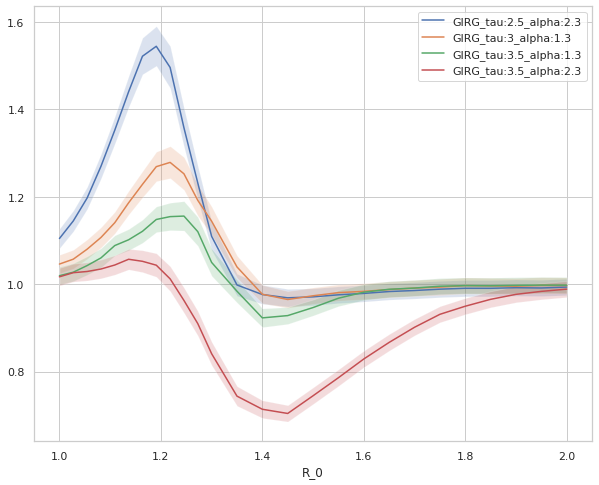

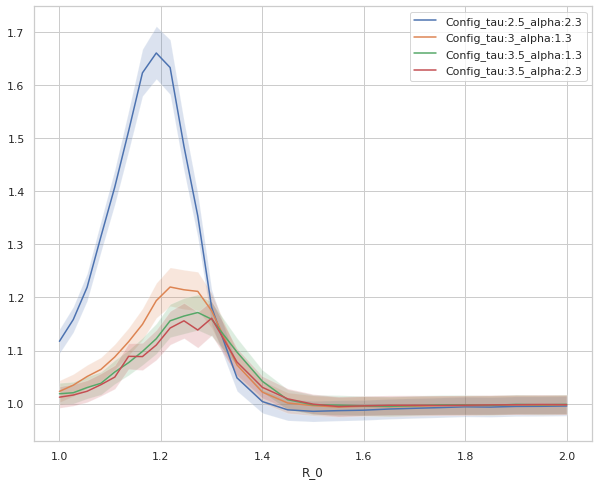

In [15]:
for files in [["GIRG_tau:2.5_alpha:2.3","GIRG_tau:3_alpha:1.3",
                 "GIRG_tau:3.5_alpha:1.3","GIRG_tau:3.5_alpha:2.3"],
              ["Config_tau:2.5_alpha:2.3","Config_tau:3_alpha:1.3",
                  "Config_tau:3.5_alpha:1.3","Config_tau:3.5_alpha:2.3"]]:
    plt.figure(figsize=(10,8))
    for file in files:
        df = pd.read_csv("girgs_final/{}_seed:{}.csv".format(file, 0))
        for seed in range(0,25):
            df_temp = pd.read_csv("girgs_final/{}_seed:{}.csv".format(file, seed))
            df = pd.merge(df,df_temp, how='inner', left_on=['beta','cen'], right_on=['beta','cen'])

        df["mean"] = df.drop(['beta', 'cen'], axis=1).mean(1)
        df["std"] = df.drop(['beta', 'cen'], axis=1).std(1)

        df.to_csv("girgs_final/aggregation/"+file+"_all.csv")
        df_agg = save_file(df, file)

        plt.plot(betas/args["--gamma"], df_agg["ratio"].values, label=file)
        plt.fill_between(betas/args["--gamma"], df_agg["lower"].values, df_agg["upper"].values,
                         alpha=0.2)
    plt.xlabel("R_0")
    plt.legend()
    plt.show()